In [1]:
# !pip install yfinance
# !pip install matplotlib
# !pip install statsmodels
# !pip install scikit-learn
# import sys
# print(sys.executable)
# !pip install pmdarima
# !pip install --upgrade numpy
# print(pd.__version__)
# !pip install numpy==1.26.4

In [2]:
# msft.info
# msft.calendar
# msft.analyst_price_targets
# msft.quarterly_income_stmt
# msft.history(period='1mo')
# msft.option_chain(msft.options[0]).calls

# Data Acqusition & Preprocessing

In [58]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima

In [ ]:
# retrieving historical data for Microsoft (MSFT) stock
# for the last 60 days with a 5-minute interval
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="max", 
    interval="1d",
)

print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-03-18 09:30:00-04:00  386.107391  387.369995  385.329987  386.220001   
2025-03-18 09:35:00-04:00  386.000000  386.019989  385.109985  385.429993   
2025-03-18 09:40:00-04:00  385.434998  385.434998  382.954987  383.019989   
2025-03-18 09:45:00-04:00  382.920013  383.769989  382.500000  383.660004   
2025-03-18 09:50:00-04:00  383.579987  384.029999  382.880005  383.950012   

                           Volume  Dividends  Stock Splits  
Datetime                                                    
2025-03-18 09:30:00-04:00  696462        0.0           0.0  
2025-03-18 09:35:00-04:00  280119        0.0           0.0  
2025-03-18 09:40:00-04:00  338583        0.0           0.0  
2025-03-18 09:45:00-04:00  302897        0.0           0.0  
2025-03-18 09:50:00-04:00  223882        0.0           0.0  


In [5]:
# msft_df.loc['2025-03-07']
# msft_df.loc['2025-06-09']
# msft_df.info()
# msft_df.describe()
# msft_df.isnull().sum()
# msft_df.isnull().values.any()
# print(msft_df[msft_df[msft_df.isnull().any(axis=1)]])
# print(msft_df[msft_df.duplicated()])

*Because of the nature of stock markets being closed on weekend, there is a gap for those specific dates. Arima handles this with sequential indexing instead of needing to fill with artifical values for regular time intervals.*

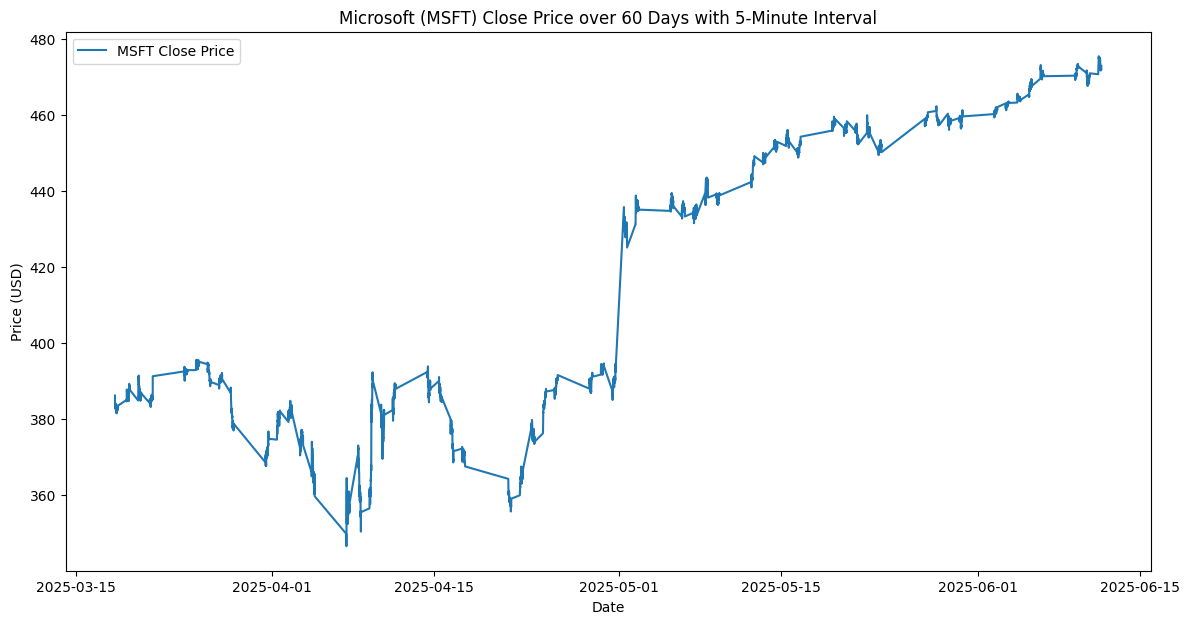

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

<Axes: ylabel='Density'>

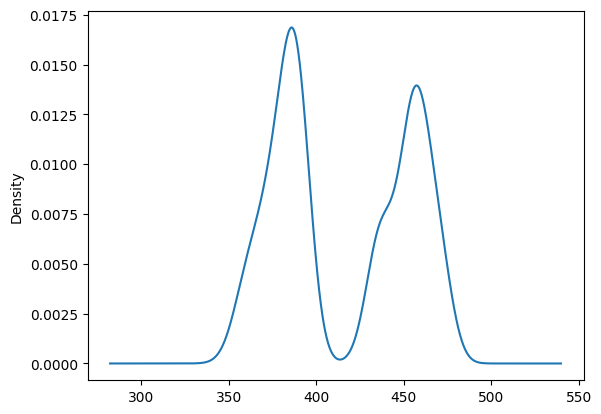

In [7]:
msft_df['Close'].plot(kind='kde')

In [8]:
start_date = '2025-04-30 15:55:00-04:00'
end_date = '2025-05-01 15:55:00-04:00'
print("close price on April 30th:", msft_df.loc[start_date]['Close'])
print("close price on May 1st:", msft_df.loc[end_date]['Close'])
print("Bimodal data is due to the quarterly earnings report, which hiked the price overnight.")

close price on April 30th: 392.3999938964844
close price on May 1st: 425.1300048828125
Bimodal data is due to the quarterly earnings report, which hiked the price overnight.


# Checking for stationarity (statistical properties are constant) 

## Rolling Mean + Rolling Standard Deviation Test

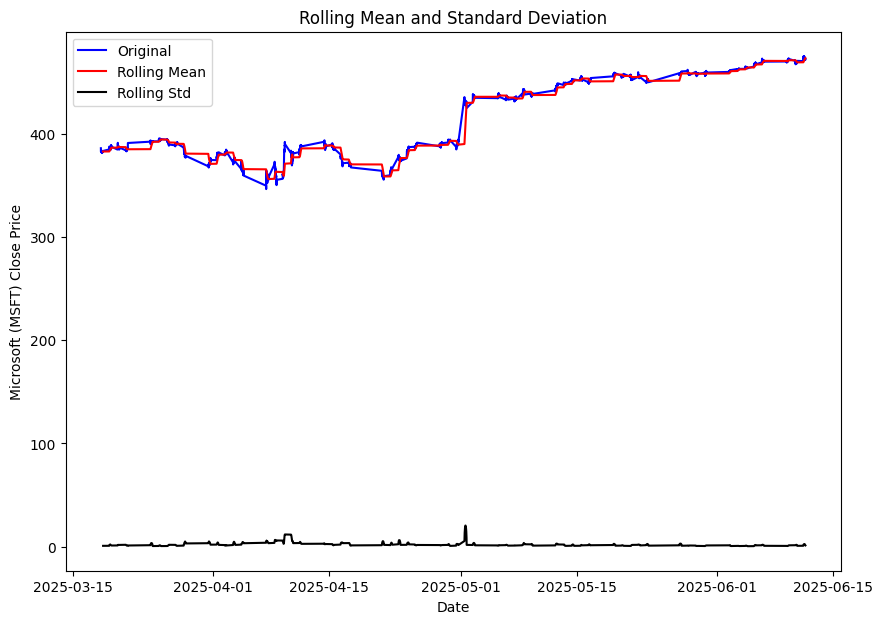

In [9]:
plt.figure(figsize=(10, 7))
rmean = msft_df['Close'].rolling(window=78).mean()
rstd = msft_df['Close'].rolling(window=78).std()
plt.plot(msft_df['Close'], color='blue', label='Original')
plt.plot(rmean, color='red', label='Rolling Mean')
plt.plot(rstd, color='black', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean and Standard Deviation')
plt.ylabel('Microsoft (MSFT) Close Price')
plt.xlabel('Date');

### Conclusion: The rolling mean and the rolling standard deviation are non constant. 

## Augmented dickey-fuller test:

* Null Hypothesis: Series is not stationary (there is a trend, changing/mean variance, or other non stationary).
* Alternative hypothesis: Series is stationary.

In [10]:
result = adfuller(msft_df["Close"])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:    
    print("Interpretation: The original series is Stationary.")
else:    
    print("Interpretation: The original series is Non-Stationary.")

ADF Statistic: -0.4746
p-value: 0.8969
Interpretation: The original series is Non-Stationary.


### ADF Conclusion: The p-value > 0.05, therefore the data is non-stationary

<Figure size 640x480 with 0 Axes>

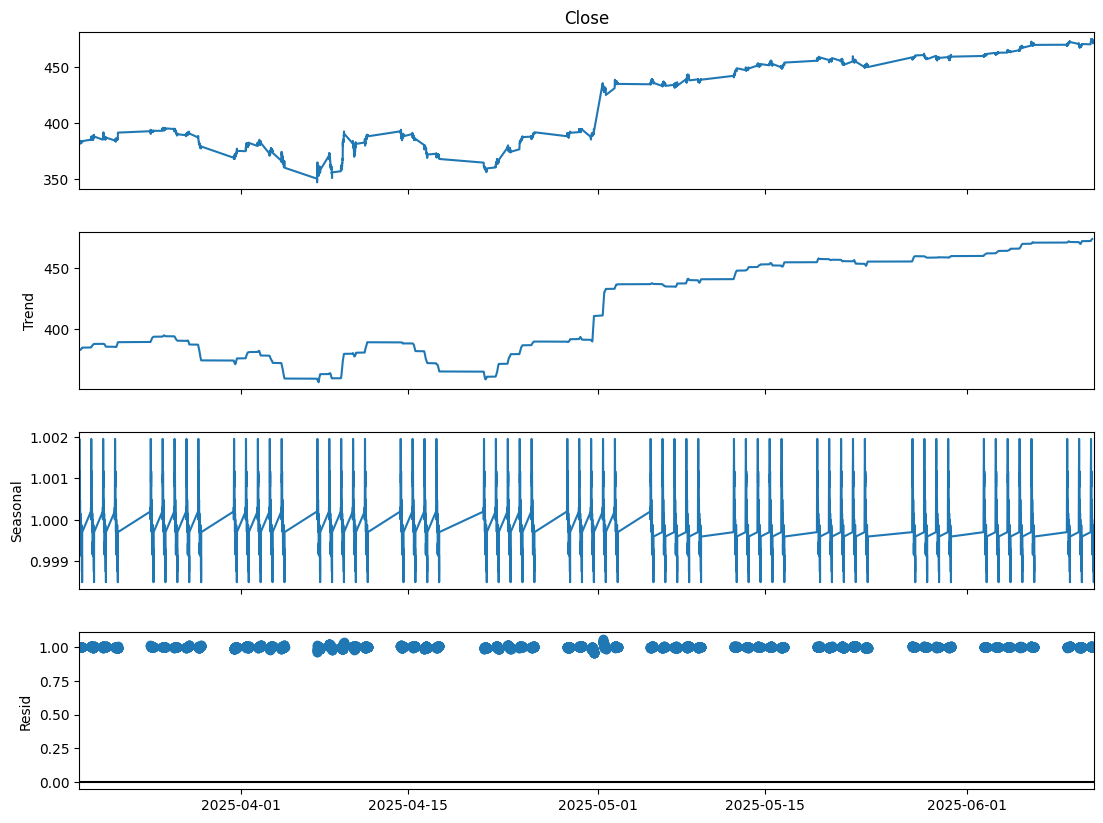

In [11]:
result = seasonal_decompose(msft_df["Close"], model='multiplicative', period=78)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 9)
plt.show();

#### For a multiplicative model decomposition, Residual = 1 means No unexplained variation at that point; the trend × seasonal fully explains the observed value.

### Differencing (Order 1) 
* Removes Trends (but not necessarily seasonlity)

In [12]:
msft_df['log_close'] = np.log(msft_df['Close'])
msft_df['Close_Diff'] = msft_df['log_close'].diff()
result_diff = adfuller(msft_df["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:    
    print("Interpretation: The differenced series is Stationary.")
else:    
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -22.0969
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


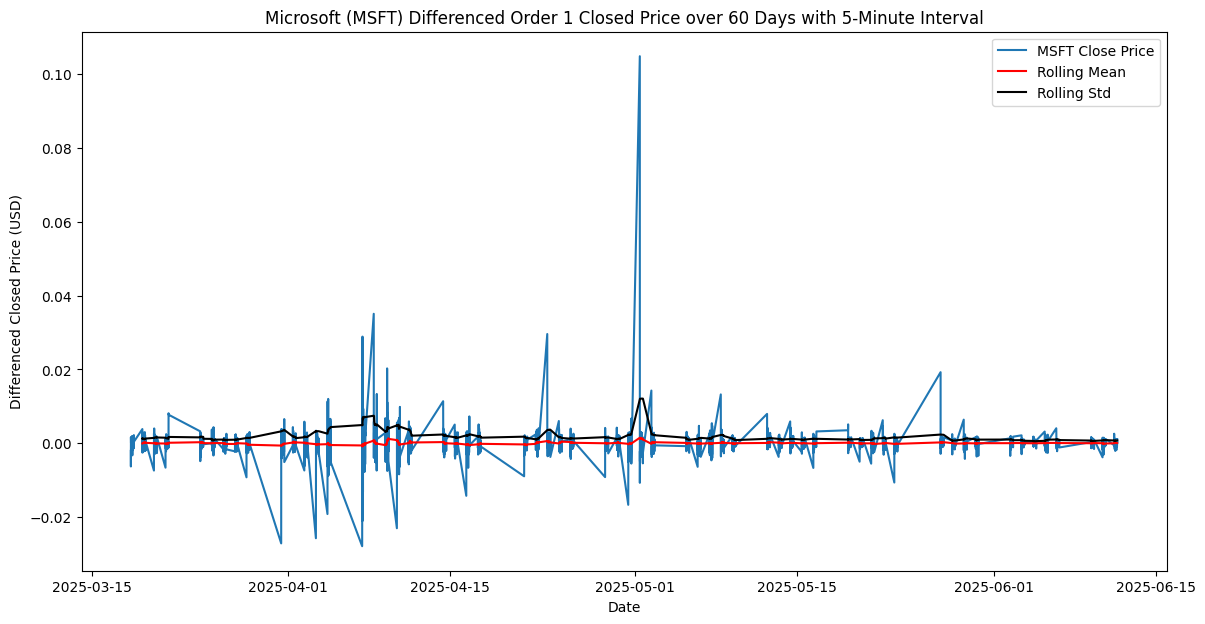

In [13]:
rmean = msft_df['Close_Diff'].rolling(window=78).mean()
rstd = msft_df['Close_Diff'].rolling(window=78).std()
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close_Diff'], label='MSFT Close Price')
plt.plot(rmean, color='red', label='Rolling Mean')
plt.plot(rstd, color='black', label='Rolling Std')
plt.title('Microsoft (MSFT) Differenced Order 1 Closed Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Differenced Closed Price (USD)')
plt.legend();

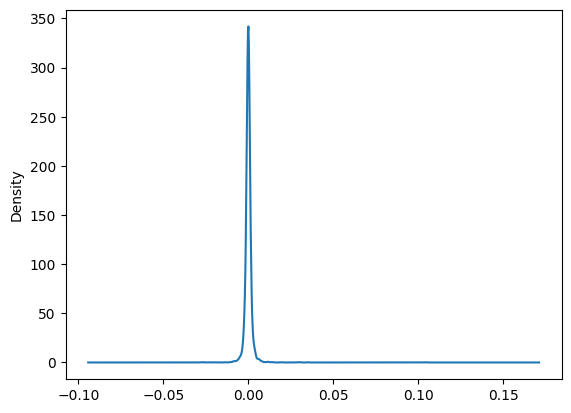

In [14]:
msft_df['Close_Diff'].plot(kind='kde');

### Conclusion: Differencing of Order 1 successfully stationaried the data.

In [15]:
# msft_df['Close_Diff2'] = msft_df['Close_Diff'].diff()
# result_diff = adfuller(msft_df["Close_Diff2"].dropna())
# print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
# print(f"p-value (Differenced): {result_diff[1]:.4f}")
# if result_diff[1] < 0.05:    
#     print("Interpretation: The differenced series is Stationary.")
# else:    
#     print("Interpretation: The differenced series is Non-Stationary.")

In [16]:
# plt.figure(figsize=(14, 7))
# plt.plot(msft_df.index, msft_df['Close_Diff2'], label='MSFT Close Price')
# plt.title('Microsoft (MSFT) Differenced Order 2 Closed Price over 60 Days with 5-Minute Interval')
# plt.xlabel('Date')
# plt.ylabel('Differenced Closed Price (USD)')
# plt.legend()

In [17]:
# # calculating auto correlation for a lag of 1
# X = np.array([100, 102, 105, 107, 109])
# mean_X = np.mean(X)
# deviations = X - mean_X
# print(deviations)
# lagged_deviations = np.roll(deviations, shift=1)
# lagged_deviations[0] = 0 
# print(lagged_deviations)
# autocorrelation = np.sum(deviations * lagged_deviations) / np.sum(deviations ** 2)
# print("Autocorrelation at lag 1:", autocorrelation)

<Figure size 1400x700 with 0 Axes>

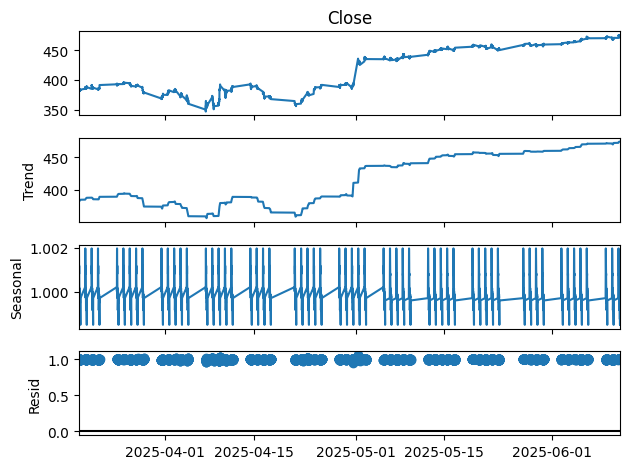

In [18]:
result = seasonal_decompose(msft_df['Close'], model='multiplicative', period=78)
plt.figure(figsize=(14, 7))
result.plot();

### Arima Parameters:
* p(Autoregressive Order): the number of lagged observations
* d(Differencing Order): refers to the order of differencing
* q(Moving Average Order): the number of lagged forecast errors included in the model

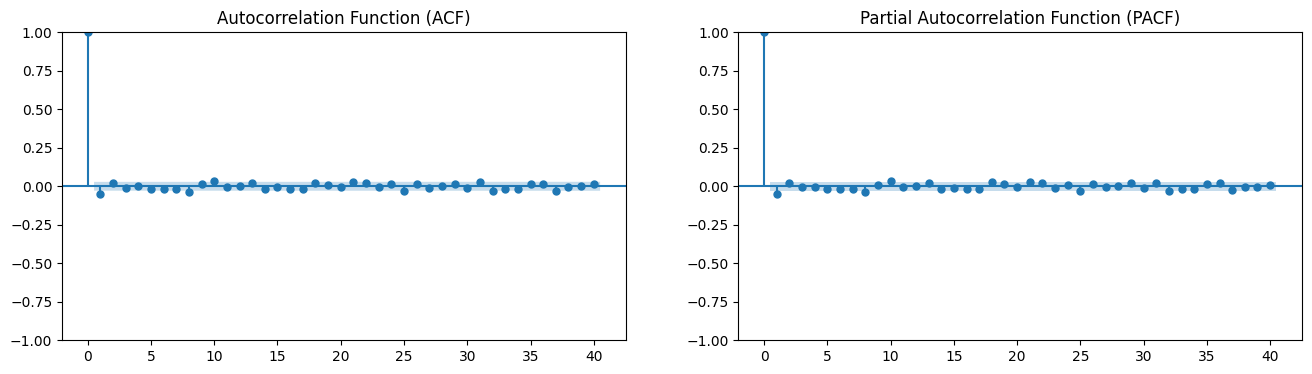

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(msft_df['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(msft_df['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

* ACF Lag 1 Spike
* PACF Lag 1 Spike
* We have a strong correlation with immediate past values; so, we'll use 1 for AR and MA. And we've already used 1.

In [20]:
train_size = int(len(msft_df) * 0.8)
train, test = msft_df.iloc[:train_size], msft_df.iloc[train_size:]
arima_model = ARIMA(train["Close_Diff"], order=(1,1,1))
arima_fit = arima_model.fit()

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

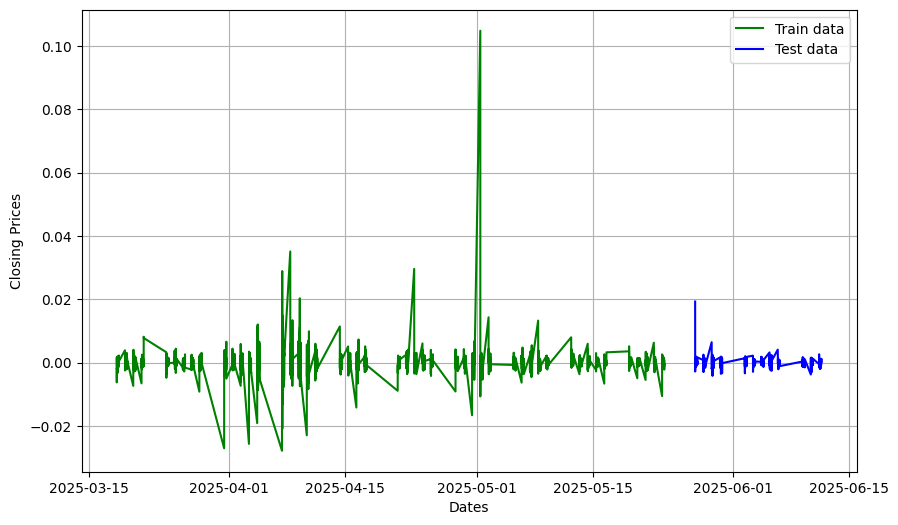

In [21]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train["Close_Diff"], 'green', label='Train data')
plt.plot(test["Close_Diff"], 'blue', label='Test data')
plt.legend();

#### Gap in training data due to memorial day

The .fit() method for the ARIMA model estimates (learns) the best parameters for the ARIMA model using your training data. It finds the coefficients for the autoregressive, differencing, and moving average terms that best explain the patterns in your data.

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


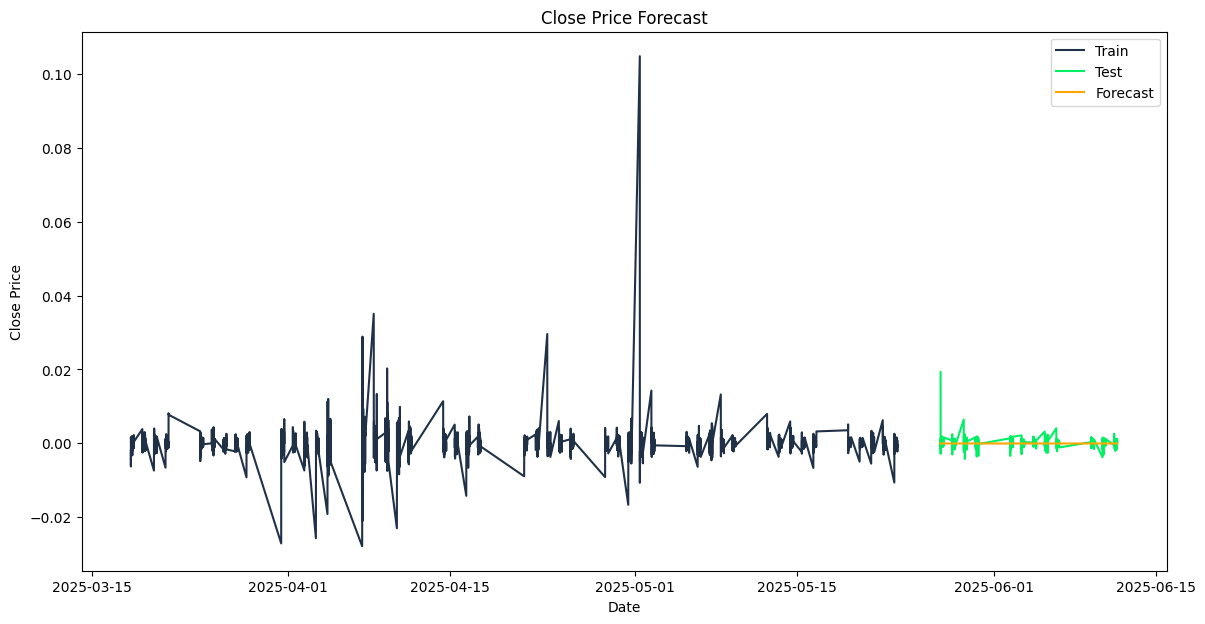

In [22]:
forecast = arima_fit.forecast(steps=len(test))
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close_Diff"], label='Train', color='#203147')
plt.plot(test.index, test["Close_Diff"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [23]:
print(f"AIC: {arima_fit.aic}")
print(f"BIC: {arima_fit.bic}")
print(f"On average, our model's predictions deviate from the actual by: {mean_squared_error(test['Close_Diff'], forecast)}")

AIC: -33070.92095481651
BIC: -33052.23882829601
On average, our model's predictions deviate from the actual by: 1.1430245797617217e-06


### Repeating the Process with hyperparameter tuning built in

In [ ]:
msft_df['log_close'] = np.log(msft_df['Close'])
train_size = int(len(msft_df) * 0.8)
train, test = msft_df.iloc[:train_size], msft_df.iloc[train_size:]

### HyperParameter Selection P, D, Q

In [ ]:
model_autoARIMA = auto_arima(train['log_close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # shows all the steps
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
arima_model = ARIMA(train['log_close'], order=(1,1,1)).fit()
arima_model.summary()                   

In [68]:
pd.Series(forecast, index=test['log_close'].index)

Datetime
2025-05-27 09:30:00-04:00   NaN
2025-05-27 09:35:00-04:00   NaN
2025-05-27 09:40:00-04:00   NaN
2025-05-27 09:45:00-04:00   NaN
2025-05-27 09:50:00-04:00   NaN
                             ..
2025-06-11 15:35:00-04:00   NaN
2025-06-11 15:40:00-04:00   NaN
2025-06-11 15:45:00-04:00   NaN
2025-06-11 15:50:00-04:00   NaN
2025-06-11 15:55:00-04:00   NaN
Name: predicted_mean, Length: 936, dtype: float64

In [69]:
forecast.min()

6.109653294144635

In [70]:
forecast.max()

6.109661663978406

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


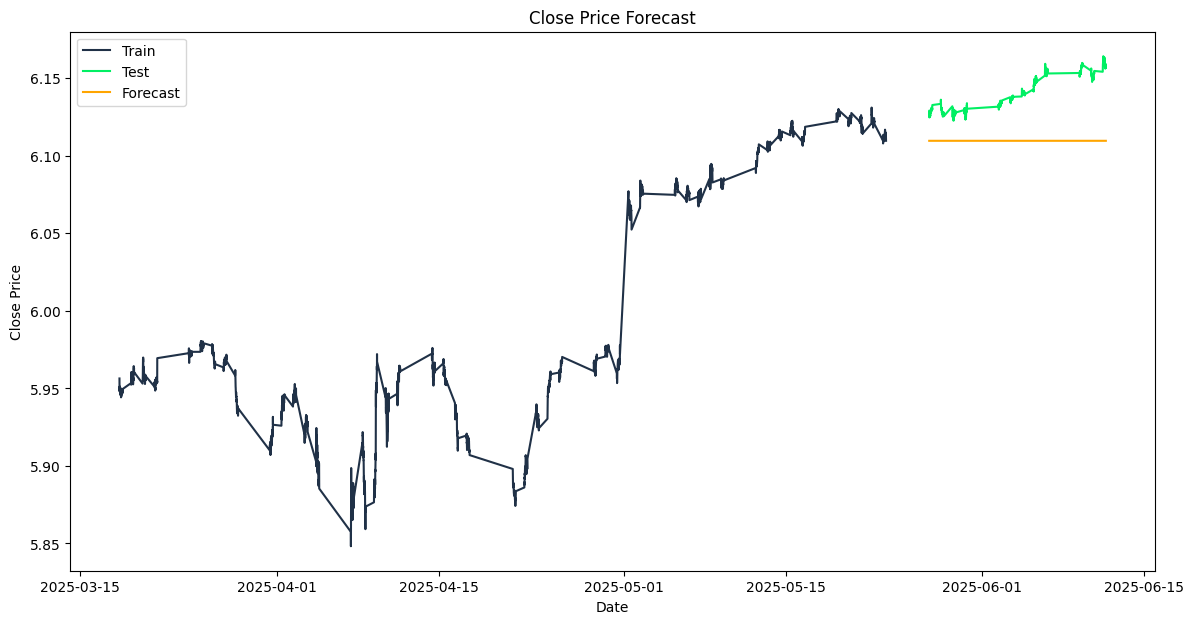

In [62]:
forecast = arima_model.forecast(steps=len(test), alpha=0.05)

plt.figure(figsize=(14,7))
plt.plot(train.index, train['log_close'], label='Train', color='#203147')
plt.plot(test.index, test["log_close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [61]:
mse = mean_squared_error(test['log_close'], forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(test['log_close'], forecast)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test['log_close'], forecast))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(test['log_close'], forecast)
print('MAPE: '+str(mape))

MSE: 0.001133117188899839
MAE: 0.03147558848713048
RMSE: 0.03366180608493607
MAPE: 0.005121615616894349
